In [10]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import wordpunct_tokenize
from collections import Counter
import sqlite3
from wordcloud import WordCloud

%matplotlib inline

morph = MorphAnalyzer()


Откроем базу данных

In [2]:
con = sqlite3.connect('vk_api_pm.db')
cur = con.cursor()

In [3]:
my_tab_query = """
SELECT user_id, sex FROM users
"""

cur.execute(my_tab_query)
data = cur.fetchall()

dt = pd.DataFrame(data)

dt

,0,1
0,264408424,male
1,326321938,male
2,571389402,female
3,147619541,female
4,189722506,female
...,...,...
95,214620928,female
96,54279089,female
97,455652872,female
98,143074121,female


Для начала выдвинем более простые гипотезы: например, мне кажется, что комментарии в пабликах активнее оставляют представительницы женского пола. Проверим:

Text(0.5, 1.0, 'Сколько людей какого пола в выборке')

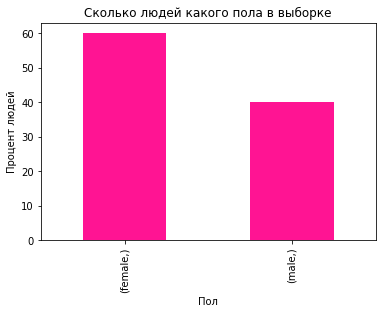

In [74]:
dt.value_counts([1]).plot(kind="bar", color='deeppink')
plt.xlabel('Пол')
plt.ylabel('Процент людей')
plt.title('Сколько людей какого пола в выборке')

Теория оказалась верной
Посмотрим дальше на разные гипотезы, для этого надо достать всю информацию из баз данных:

In [5]:
comment_query = """
SELECT a.comment_id, a.comment_thread, a.user_id, b.comment_id, b.text, b.lemmatized_text, c.user_id, c.sex, c.city
FROM comments_meta a
JOIN comments b ON a.comment_id = b.comment_id
JOIN users c ON a.user_id = c.user_id

"""

cur.execute(comment_query)
data2 = cur.fetchall()

df = pd.DataFrame(data2, columns=["comment_id", "replies", 'user_id', 'comment_id', 'text', 'lemmatized_text', 'user_id1', 'sex', 'city'])

df

,comment_id,replies,user_id,comment_id,text,lemmatized_text,user_id1,sex,city
0,29024,0,264408424,29024,"Пиздец, а чего тут нет","пиздец,",264408424,male,0
1,28865,2,264408424,28865,Вкину своё.\nХотя можно и так.\nhttps://vk.com...,вкинуть своё.\nхотя так.\nhttps://vk.com/album...,264408424,male,0
2,28810,4,264408424,28810,"Почему мне кажется, что последнее наоборот дол...","почему кажется, последний наоборот должный быть?",264408424,male,0
3,28635,1,264408424,28635,Ведро важное мнение,вёдро важный мнение,264408424,male,0
4,28595,0,264408424,28595,Это так я вижу холодильник\nКак он выглядит на...,это видеть холодильник\nкак выглядеть самый дело,264408424,male,0
...,...,...,...,...,...,...,...,...,...
995,6513,3,150466749,6513,Хэлб helb битлз beatles,хэлба helb битлз beatles,150466749,male,0
996,6274,0,150466749,6274,минимализм каламбур поток,минимализм каламбур поток,150466749,male,0
997,6251,0,150466749,6251,are you kidding me meme серьезно,are you kidding me meme серьёзно,150466749,male,0
998,5402,0,150466749,5402,Мерч плюшевый,мерч плюшевый,150466749,male,0


Уберём лишние столбики

In [6]:
df.drop(['comment_id', 'user_id1'], axis=1) 

,replies,user_id,text,lemmatized_text,sex,city
0,0,264408424,"Пиздец, а чего тут нет","пиздец,",male,0
1,2,264408424,Вкину своё.\nХотя можно и так.\nhttps://vk.com...,вкинуть своё.\nхотя так.\nhttps://vk.com/album...,male,0
2,4,264408424,"Почему мне кажется, что последнее наоборот дол...","почему кажется, последний наоборот должный быть?",male,0
3,1,264408424,Ведро важное мнение,вёдро важный мнение,male,0
4,0,264408424,Это так я вижу холодильник\nКак он выглядит на...,это видеть холодильник\nкак выглядеть самый дело,male,0
...,...,...,...,...,...,...
995,3,150466749,Хэлб helb битлз beatles,хэлба helb битлз beatles,male,0
996,0,150466749,минимализм каламбур поток,минимализм каламбур поток,male,0
997,0,150466749,are you kidding me meme серьезно,are you kidding me meme серьёзно,male,0
998,0,150466749,Мерч плюшевый,мерч плюшевый,male,0


Посмотрим на зависимость количества ответов на комментарий в зависимости от количества слов в нём. Мне кажется, что чем больше слов, тем больше ответов.

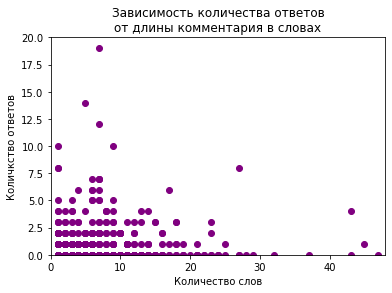

In [7]:
X = []
for c_t in df['text'].values.tolist():
    X.append(len(c_t.split(' ')))
Y = df['replies'].values.tolist()

plt.ylabel('Количкство ответов')
plt.xlabel('Количество слов')
plt.title('Зависимость количества ответов\nот длины комментария в словах')
plt.ylim((0, 20))
plt.xlim((0, 48))

plt.scatter(X, Y, color='purple', label='group 1')
plt.show()

В основном, кажется, что все наоборот - много ответов етсь только на комментарии, в которых меньше 20 слов. 

In [9]:
all_the_words = []
for c_t in df['lemmatized_text'].values.tolist():
    for w in c_t.split(' '):
        all_the_words.append(w)
print(all_the_words)

['пиздец,', '', 'вкинуть', 'своё.\nхотя', 'так.\nhttps://vk.com/album264408424_269034103', '', 'почему', 'кажется,', 'последний', 'наоборот', 'должный', 'быть?', '', 'вёдро', 'важный', 'мнение', '', 'это', 'видеть', 'холодильник\nкак', 'выглядеть', 'самый', 'дело', '', '>блять', 'егор', '', 'пацанский', 'цитата', '', 'я', 'обьяснять', 'маме\nть', 'пытаться', 'объяснить', 'мама', '', '', '', '', '', 'знание', 'сила', '', 'благоухать', 'вкусно', 'пахнуть', 'приятно', '', 'шок', 'жесть', 'насилие', 'угроза', '', 'кивать', '', 'ужасно', 'страх', 'дедлайна', '', 'паблик', 'умирать', 'паблик', 'спячка', 'победа', 'воодушевление', 'вдохновение', 'ложь', '', 'еее', 'рок', '', 'контраст', 'противоположность', 'слева', 'улыбаться', 'смеяться', 'справа', 'грустный', 'злой', 'половина', 'половинка', 'часть', '', 'прикидываться', 'притворяться', 'больной', 'больница', 'обманывать', 'наебывать', '', 'балерина', 'жесть', 'реально', 'борщ', '', 'звать', 'копов\n\nлегушька', 'самокате\n\nть', 'давать',

Ещё одна гипотеза - в связи с тем, что это комментарии в группе с мемами, одно из самых популырнях слов будет "мем"

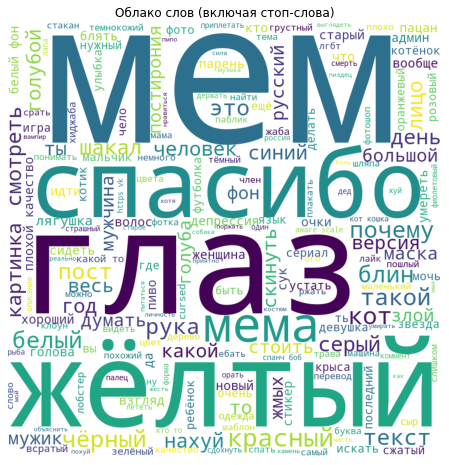

In [11]:
text = ' '.join(all_the_words)

wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate(text)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов (включая стоп-слова)')
plt.show()

Ура, это оказалось верным! (а ещё все остальные большие слова какие-то неожиданные)

Напишем функцию, которая определяет количество мата в комментариях каждого пола. Мне кажется, что представители мужского пола матеряся больше

In [40]:
def swear_words(sex):
    swear_words = ['пиздец', 'блять', 'блядь', 'нахуй', 'хуйня', 'сука', 'пизда', 'ебать', 'бля', 'похуй']
    sex_counter = 0
    s = []
    sex_texts = []

    s.append(list(df[df['sex']==sex]['lemmatized_text'].iloc))
    for strocka in s[0]:
        for word in strocka.split(' '):
            sex_texts.append(word)

    sex_texts = list(filter(None, sex_texts))
    for a in sex_texts:
        a = a.replace(',', '')
        a = a.replace('.', '')
        if a in swear_words:
            sex_counter += 1
        else: 
            pass
    per_cent_sex = sex_counter/len(sex_texts)*100   
    return per_cent_sex

In [48]:
male_swears = swear_words('male')
female_swears = swear_words('female')
sex_sw = [male_swears, female_swears]
sexes = ['male', 'female']

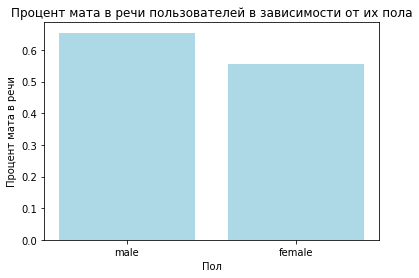

In [76]:
plt.bar(sexes, sex_sw, color='lightblue')
plt.ylabel('Процент мата в речи')
plt.xlabel('Пол')
plt.title('Процент мата в речи пользователей в зависимости от их пола')
plt.show()

И снова - ура, гипотеза подтвердилась!

Ну и последняя гипотеза - в связи со спецификой паблика, комментарии из которого я выкачиваю, большая часть слов должна оказаться существительными.

In [57]:
pos = []
text = text.replace(',', '')
text = text.replace('\n', '')
text = text.replace('.', '')
for word in text:
    ana = morph.parse(word)
    first = ana[0]
    tags = str(first.tag).split(',')
    if tags[0] == 'UNKN':
        pass
    else: 
        pos.append(tags[0])

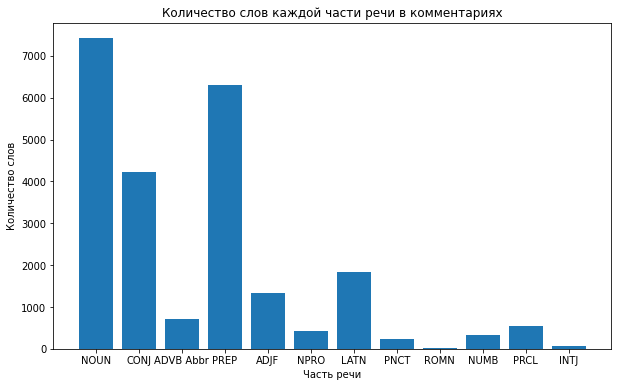

In [77]:
cnt = Counter(pos)
plt.figure(figsize=(10, 6))
plt.bar(dict(cnt).keys(), dict(cnt).values())
plt.xlabel('Часть речи')
plt.ylabel('Количество слов')
plt.title('Количество слов каждой части речи в комментариях')
plt.show()

Гипотеза снова оказалась верна!)